In [1]:
import torch
import torchvision
from torchvision.utils import make_grid
import torch
import torch.utils.data 
from torch import nn

import math
from torch.cuda import amp

from spikingjelly.activation_based import functional
from spikingjelly.datasets import dvs128_gesture

import numpy as np
import argparse
import matplotlib.pyplot as plt

import sys

sys.path.append('./..')

import deepModelsDVS, utils

/home/shihao/miniconda3/envs/spikingEnv/lib/python3.9/site-packages/tqdm-4.64.1-py3.9.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')

In [3]:
def load_data(dataset_dir, distributed, T):
    # Data loading code
    print("Loading data")

    dataset_train = dvs128_gesture.DVS128Gesture(root=dataset_dir, train=True, data_type='frame', frames_number=T, split_by='number')
    dataset_test = dvs128_gesture.DVS128Gesture(root=dataset_dir, train=False, data_type='frame', frames_number=T, split_by='number')

    print("Creating data loaders")
    if distributed:
        train_sampler = torch.utils.data.distributed.DistributedSampler(dataset_train)
        test_sampler = torch.utils.data.distributed.DistributedSampler(dataset_test)
    else:
        train_sampler = torch.utils.data.RandomSampler(dataset_train)
        test_sampler = torch.utils.data.SequentialSampler(dataset_test)

    return dataset_train, dataset_test, train_sampler, test_sampler

In [4]:
data_path = './../datasets/DVSGesture'
dataset_train, dataset_test, train_sampler, test_sampler = load_data(data_path, False, 16)
print(f'dataset_train:{dataset_train.__len__()}, dataset_test:{dataset_test.__len__()}')

data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size= 4,
    sampler=train_sampler, num_workers= 4, pin_memory=True)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size= 4,
    sampler=test_sampler, num_workers= 4, pin_memory=True)

Loading data
The directory [./../datasets/DVSGesture/frames_number_16_split_by_number] already exists.
The directory [./../datasets/DVSGesture/frames_number_16_split_by_number] already exists.
Creating data loaders
dataset_train:1176, dataset_test:288


In [5]:
# Load the model that we saved at the end of the training loop 
model = deepModelsDVS.__dict__['SEWResNet']('ADD') #deepModelsDVS.SEWResNet(args.connect_f)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=64, gamma=0.1)

path = "/home/shihao/ProjectDiego/code/logs/posterLogs/DVS128/DeepDVS_SEWResNet_b4_epochs192_T16_Ttrain12_steplr64_0.001_sgd_cnf_ADD/lr0.001/checkpoint_max_test_acc1.pth" 
model_without_ddp = model
checkpoint = torch.load(path, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
start_epoch = checkpoint['epoch'] + 1
max_test_acc1 = checkpoint['max_test_acc1']
test_acc5_at_max_test_acc1 = checkpoint['test_acc5_at_max_test_acc1']
print("Model created")


Model created


In [6]:
from random import randint

def showImage(x, label):
    # x.shape: 4, 16, 2, 128, 128
    # x, label = train_set_CIFAR10DVS[0] # 16, 2, 128, 128 example

    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    to_img = torchvision.transforms.ToPILImage()
    img_tensor = torch.zeros([x.shape[0], x.shape[1], 3, x.shape[3], x.shape[4]])
    img_tensor[:, :, 1] = x[:, :, 0]
    img_tensor[:, :, 2] = x[:, :, 1]

    #img_list = []
    tensor_list = []
    for t in range(img_tensor.shape[0]):
        #for k in range(img_tensor.shape[1]):
            #ext= img_tensor[t,k]
            #print(ext.shape)
        #    tensor_list.append(img_tensor[t,k])
        #img_list.append(to_img(img_tensor[t]))
        k = randint(0,15)
        tensor_list.append(img_tensor[t,k])
    print(len(tensor_list))
    imgP = to_img(make_grid(tensor_list, nrow=1))


    fig = plt.figure(frameon=False)
    fig.set_size_inches(3,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    ax.imshow(imgP, aspect='auto')
    #fig.savefig("./../images/airplane.svg", dpi=300)

    print(label)
    plt.show()

    return fig

In [9]:
def evaluate(model, criterion, data_loader, device, print_freq=100, header='Test:'):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    with torch.no_grad():
        i = 0
        for image, target in metric_logger.log_every(data_loader, print_freq, header):
            if i%42==0:
                image = image.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True)
                image = image.float()
                #print(image.shape)
                output = model(image)
                maxk = max((1,))
                _, pred = output.topk(maxk, 1, True, True)
                pred = pred.t()
                correct = pred.eq(target[None])
                #print(target, pred)
                loss = criterion(output, target)
                functional.reset_net(model)
                
                fig = showImage(image, pred)
                strPred = str(pred)
                name = strPred[8:20] + str(i) +"vert"
                fig.savefig("./../images/"+name+".svg", dpi=300)

                acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
                batch_size = image.shape[0]
                metric_logger.update(loss=loss.item())
                metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
                metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
            i += 1
            #break
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()

    loss, acc1, acc5 = metric_logger.loss.global_avg, metric_logger.acc1.global_avg, metric_logger.acc5.global_avg
    print(f' * Acc@1 = {acc1}, Acc@5 = {acc5}, loss = {loss}')
    return loss, acc1, acc5

4
tensor([[0, 0, 0, 0]], device='cuda:0')


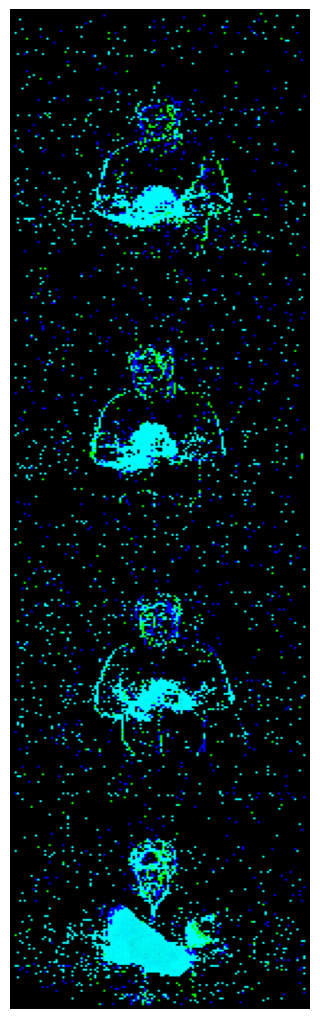

Test:  [ 0/72]  eta: 0:00:35  loss: 0.1224 (0.1224)  acc1: 100.0000 (100.0000)  acc5: 100.0000 (100.0000)  time: 0.4918  data: 0.2432  max mem: 1065
4
tensor([[7, 7, 7, 7]], device='cuda:0')


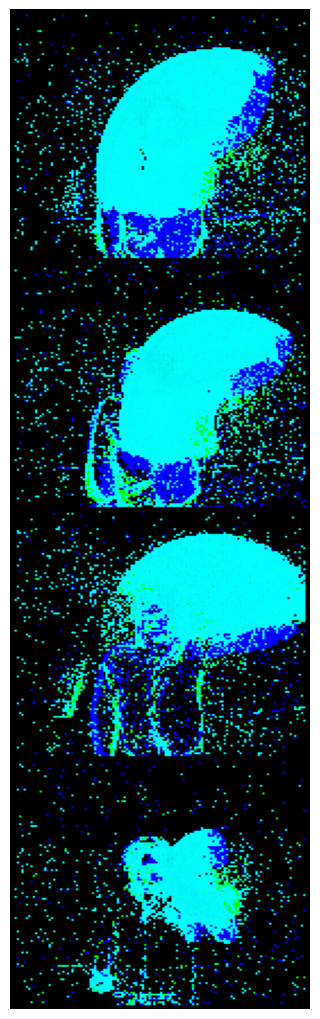

Test: Total time: 0:00:01
 * Acc@1 = 100.0, Acc@5 = 100.0, loss = 0.22326543182134628


In [10]:
criterion = nn.CrossEntropyLoss()
test_loss, test_acc1, test_acc5 = evaluate(model, criterion, data_loader_test, device=device, header='Test:')
